In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from copy import deepcopy 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

### Solution using CVX

In [388]:
def generate_params(size):
    mu = np.linspace(0.05,0.50,size)
    sigma = np.diag(mu+0.05)**2
    for i in range(size):
        for j in range(i+1, size):
            sigma[i][j] = 0.35 * np.sqrt(sigma[i][i]*sigma[j][j])
            sigma[j][i] = sigma[i][j]
    return mu, sigma

beta = 5
lamda = 0.1

size = 3
mu = np.array([0.1073,0.0737,0.0627])
sigma = np.array([[0.02778,0.00387,0.00021],[0.00387,0.01112,-0.00020],[0.00021,-0.00020,0.00115]])
R = 0.085

# size = 10
# mu, sigma = generate_params(size)
# R = 0.4

def get_optimal_ubsr(mu=mu,sigma=sigma,R=R,beta=beta,lamda=lamda):
    x = cp.Variable(size)

    # Define the objective function
    objective = -mu @ x + (beta / 2) * cp.quad_form(x, sigma) - cp.log(lamda) / beta

    # Define the constraints
    constraints = [sum(x) <= 1] + [x[i]>=0 for i in range(size)] + [mu.T @ x >= R]

    # Formulate the optimization problem
    problem = cp.Problem(cp.Minimize(objective), constraints)

    # Solve the problem
    problem.solve(solver='OSQP', max_iter=10000)
    
    if problem.status == cp.OPTIMAL:
        ubsr = -mu @ x.value + beta/2 * x.value.T @ sigma @ x.value - np.log(lamda)/beta
        return [ubsr,np.abs(np.round(x.value,5)),round(mu @ x.value,4)]
    else:
        print("Optimization problem did not converge.")
        
get_optimal_ubsr()

[0.3929111908032914, array([0.456  , 0.17841, 0.36559]), 0.085]

### Analytical Solution

In [389]:
a = np.matmul(np.matmul(mu,np.linalg.inv(sigma)),np.ones(size).reshape(-1,1))[0]
b = np.matmul(np.matmul(np.ones(size),np.linalg.inv(sigma)),np.ones(size).reshape(-1,1))[0]
c = np.matmul(np.matmul(np.ones(size),np.linalg.inv(sigma)),mu.reshape(-1,1))[0]
d = np.matmul(np.matmul(mu,np.linalg.inv(sigma)),mu.reshape(-1,1))[0]
lambda1 = beta*(a - R*b) / (a*c - b*d) - 1
lambda2 = beta*(R*c - d) / (a*c - b*d)

In [390]:
theta_star = ((1+lambda1)*np.matmul(np.linalg.inv(sigma),mu.reshape(-1,1)) + lambda2 * np.matmul(np.linalg.inv(sigma),np.ones(size).reshape(-1,1)))/beta
theta_star = theta_star.flatten()

In [391]:
theta_star

array([0.45599732, 0.17841086, 0.36559182])

In [392]:
sr_star = sr(theta_star, mu, sigma, beta, lamda)
sr_star

0.39291119080329096

### Solution using SGD

In [367]:
def returns(mu, sig):
    return np.random.multivariate_normal(mean = mu, cov = sig)

def returns_m(mu, sig, m):
    return np.random.multivariate_normal(mean = mu, cov = sig, size = m)

def loss_dash(x, beta):
    return -beta*np.exp(beta*x)

def estimate_h(beta, theta, sr, returns):
    loss_dashes = loss_dash(-np.matmul(theta,returns.T)-sr,beta)
    B_m = np.sum(loss_dashes)
    A_m = np.matmul(loss_dashes.T,-returns)
    h = A_m/B_m                                                                                                                             
    return h

def get_alpha_k(n,k,alpha0):
        i = int(np.ceil(np.log2(n)) - np.ceil(np.log2(n-k)))
        return alpha0/np.sqrt(n) * 2**(-i)

In [ ]:
Thetas = []
SRs = []
alpha0 = 100
m = 100
n = 500
theta_init = np.array([0.999,0.001,0])

for it in tqdm(range(100)):
    theta_vals = []
    sr_estimates = []
    theta_vals.append(deepcopy(theta_init))
    sr_estimates.append(sr(deepcopy(theta_init),mu,sigma,beta,lamda))
    
    theta = deepcopy(theta_init)

    for k in range(n):
        r_samples = returns_m(mu, sigma, m)
        sr_val = sr(theta/np.sum(theta), mu, sigma, beta, lamda)
        if k>0:
            return_samples = np.concatenate((return_samples,r_samples),axis=0)
        else:
            return_samples = r_samples

        r_i = np.mean(return_samples, axis = 0)
        estimate = estimate_h(beta, theta, sr_val, return_samples)

        alpha = get_alpha_k(n,k,alpha0)
        j = np.random.choice([0,1,2])
        theta[j] = theta[j] - alpha * (estimate[j] - lambda1 * r_i[j] - lambda2)
        if theta[j] < 0:
            theta[j] = 0
    #     for k in [0,1,2]:
    #         if k==j:
    #             theta[k] = theta[k] - alpha * (estimate[k] - lambda1 * r_i[k] - lambda2)
    #         if theta[k] < 0:
    #             theta[k] = 0

        #theta = theta / np.sum(theta)
        theta_vals.append(theta/np.sum(theta))
        sr_estimates.append(sr(theta/np.sum(theta), mu, sigma, beta, lamda))
    Thetas.append(theta_vals)
    SRs.append(sr_estimates)

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:43<00:11,  1.85it/s]

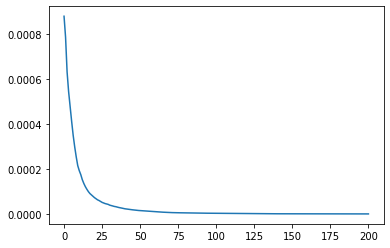

In [424]:
plt.plot(np.abs(np.mean(np.array(SRs),axis=0)-sr_star)**2)

In [425]:
Theta_Errors = []
for j in range(100):
    theta_error = []
    for i in range(len(Thetas[j])):
        theta_error.append(np.sum((Thetas[j][i]-theta_star)**2))
    Theta_Errors.append(theta_error)

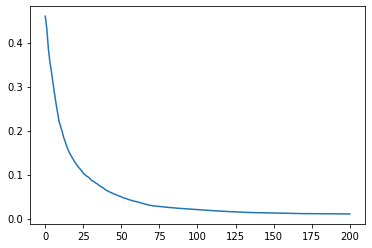

In [426]:
plt.plot(np.mean(np.array(Theta_Errors),axis=0))

In [429]:
np.mean(np.array(Thetas)[:,-1,:],axis=0)

array([0.49873025, 0.18697895, 0.3142908 ])